In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("cleaned_with_spend.csv")
df['calendar_week'] = pd.to_datetime(df['calendar_week'])
df = df.sort_values('calendar_week')

# Set index to time
df.set_index('calendar_week', inplace=True)

# Define variables
media_channels = ['spend_google', 'spend_email', 'spend_facebook', 'spend_affiliate']
control_vars = ['organic_views', 'paid_views']
target_var = 'sales'

# Apply adstock transformation
def apply_adstock(series, theta=0.5):
    result = []
    prev = 0
    for s in series:
        transformed = s + theta * prev
        result.append(transformed)
        prev = transformed
    return result

# Apply adstock to media variables
adstocked = pd.DataFrame(index=df.index)
for col in media_channels:
    adstocked[col + '_adstock'] = apply_adstock(df[col], theta=0.5)

# Optionally scale control variables
scaler = StandardScaler()
controls_scaled = pd.DataFrame(scaler.fit_transform(df[control_vars]), columns=control_vars, index=df.index)

# Merge everything
model_df = pd.concat([df[[target_var]], adstocked, controls_scaled], axis=1)


In [ ]:
# Hill saturation function
def hill_saturation(x, alpha=1.0, gamma=0.5):
    return (x ** alpha) / (x ** alpha + gamma ** alpha)

# Apply Hill saturation to adstocked media
saturated = pd.DataFrame(index=df.index)
for col in media_channels:
    adstocked_col = adstocked[col + '_adstock']
    max_val = adstocked_col.max()
    gamma = max_val * 0.5  # Half of max spend
    saturated[col + '_saturated'] = hill_saturation(adstocked_col, alpha=1.0, gamma=gamma)

# Final dataset: sales + saturated media + controls
model_df = pd.concat([df[[target_var]], saturated, controls_scaled], axis=1)

# Preview
model_df.head()

,sales,spend_google_saturated,spend_email_saturated,spend_facebook_saturated,spend_affiliate_saturated,organic_views,paid_views
calendar_week,,,,,,,
2018-01-06,59417,0.000039,0.063110,0.016362,0.106773,-0.537214,-0.477633
2018-01-06,128629,0.000109,0.159256,0.033501,0.326204,-0.544192,-0.466977
2018-01-06,195068,0.000119,0.271147,0.065011,0.465719,-0.545521,-0.484358
2018-01-06,62450,0.000079,0.205670,0.045659,0.376897,-0.519354,-0.469511
2018-01-06,287095,0.000054,0.281545,0.089080,0.529887,-0.548678,-0.480914


In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Define features and target
X = model_df.drop(columns=[target_var])
y = model_df[target_var]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# Fit Ridge with cross-validation
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train, y_train)

# Fit Lasso with cross-validation
lasso = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=10000)
lasso.fit(X_train, y_train)

# Predict
ridge_preds = ridge.predict(X_test)
lasso_preds = lasso.predict(X_test)


In [ ]:
# Evaluation Metrics
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔎 {name} Performance:")
    print("R² Score:", round(r2_score(y_true, y_pred), 4))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))

evaluate_model("Ridge", y_test, ridge_preds)
evaluate_model("Lasso", y_test, lasso_preds)



🔎 Ridge Performance:
R² Score: 0.4642
RMSE: 251814.11

🔎 Lasso Performance:
R² Score: 0.4642
RMSE: 251814.48


In [ ]:

ridge_coef = pd.Series(ridge.coef_, index=X.columns)
lasso_coef = pd.Series(lasso.coef_, index=X.columns)

print("\n📌 Ridge Coefficients:")
print(ridge_coef.sort_values(ascending=False))

print("\n📌 Lasso Coefficients:")
print(lasso_coef.sort_values(ascending=False))



📌 Ridge Coefficients:
spend_email_saturated        1.180824e+06
spend_google_saturated       6.803532e+05
spend_facebook_saturated     3.317214e+05
organic_views                1.135620e+04
paid_views                   9.535076e+03
spend_affiliate_saturated   -1.629524e+05
dtype: float64

📌 Lasso Coefficients:
spend_email_saturated        1.181012e+06
spend_google_saturated       6.803463e+05
spend_facebook_saturated     3.317042e+05
organic_views                1.135778e+04
paid_views                   9.533940e+03
spend_affiliate_saturated   -1.630450e+05
dtype: float64


C:\Users\Georges Ghosn\AppData\Local\Temp\ipykernel_11896\2985410051.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Georges Ghosn\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


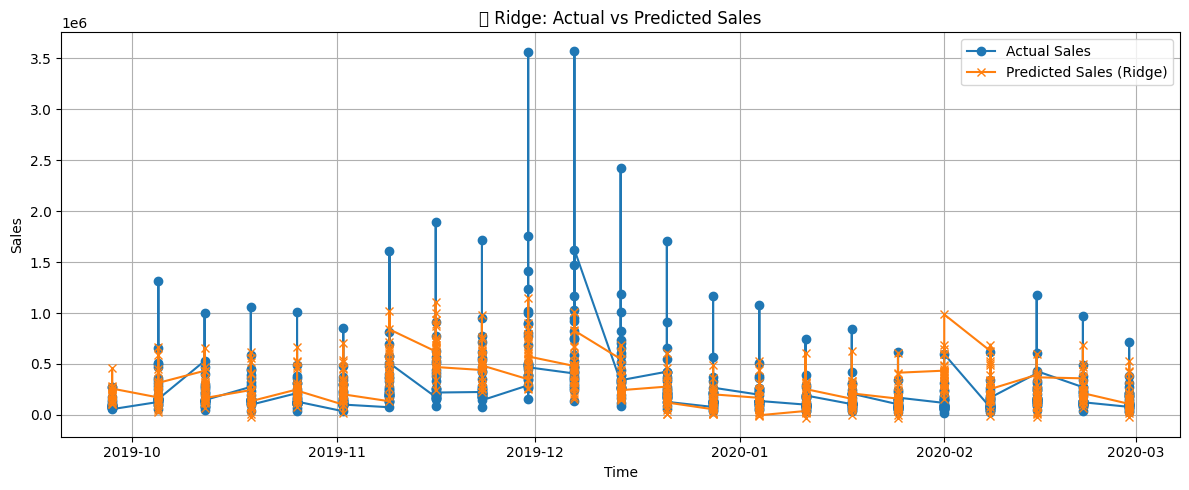

C:\Users\Georges Ghosn\AppData\Local\Temp\ipykernel_11896\2985410051.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


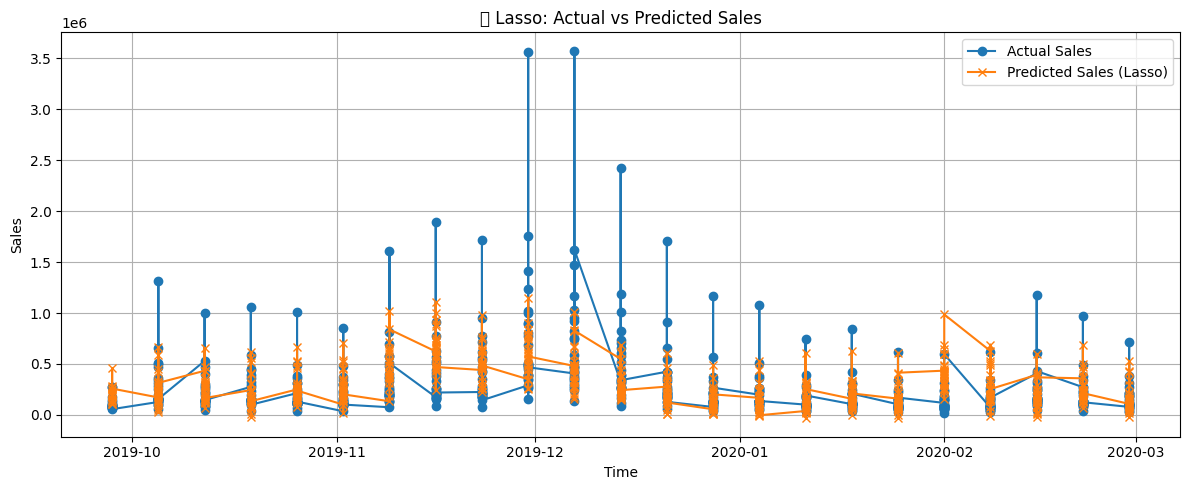

In [ ]:
import matplotlib.pyplot as plt

# --- Plot Ridge Predictions ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual Sales', marker='o')
plt.plot(y_test.index, ridge_preds, label='Predicted Sales (Ridge)', marker='x')
plt.title('📈 Ridge: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Lasso Predictions ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual Sales', marker='o')
plt.plot(y_test.index, lasso_preds, label='Predicted Sales (Lasso)', marker='x')
plt.title('📈 Lasso: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


model with seasonality :

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- PARAMETERS ---
theta = 0.5  # Adstock decay
alpha = 1.0  # Hill alpha
gamma_frac = 0.5  # Hill gamma = 50% of max spend
period = 52  # Weekly data: 52 weeks in a year
order = 1  # First Fourier harmonic

# --- STEP 1: Adstock Function ---
def apply_adstock(series, theta):
    result = [series.iloc[0]]
    for i in range(1, len(series)):
        result.append(series.iloc[i] + theta * result[i-1])
    return pd.Series(result, index=series.index)

# --- STEP 2: Apply Adstock to Media Channels ---
media_channels = ['spend_google', 'spend_facebook', 'spend_email', 'spend_affiliate']
adstocked = pd.DataFrame(index=df.index)
for col in media_channels:
    adstocked[col + '_adstock'] = apply_adstock(df[col], theta)

# --- STEP 3: Hill Saturation Function ---
def hill_saturation(x, alpha=1.0, gamma=0.5):
    return (x ** alpha) / (x ** alpha + gamma ** alpha)

# --- STEP 4: Apply Saturation ---
saturated = pd.DataFrame(index=df.index)
for col in media_channels:
    adstocked_col = adstocked[col + '_adstock']
    gamma = adstocked_col.max() * gamma_frac
    saturated[col + '_saturated'] = hill_saturation(adstocked_col, alpha=alpha, gamma=gamma)

# --- STEP 5: Add Fourier Terms (Seasonality) ---
t = np.arange(len(df))
df['sin_52'] = np.sin(2 * np.pi * t / period)
df['cos_52'] = np.cos(2 * np.pi * t / period)
controls = df[['sin_52', 'cos_52']]

# --- STEP 6: Combine Final Dataset ---
target_var = 'sales'
X = pd.concat([saturated, controls], axis=1)
y = df[target_var]

# --- STEP 7: Scale and Split ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- STEP 8: Fit Ridge and Lasso ---
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1, max_iter=10000)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# --- STEP 9: Predict and Evaluate ---
ridge_preds = ridge.predict(X_test)
lasso_preds = lasso.predict(X_test)

ridge_r2 = r2_score(y_test, ridge_preds)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
lasso_r2 = r2_score(y_test, lasso_preds)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))

# --- STEP 10: Output Results ---
print(f"🔍 Ridge R²: {ridge_r2:.4f} | RMSE: {ridge_rmse:,.2f}")
print(f"🔍 Lasso R²: {lasso_r2:.4f} | RMSE: {lasso_rmse:,.2f}")

🔍 Ridge R²: 0.5645 | RMSE: 151,179.68
🔍 Lasso R²: 0.5645 | RMSE: 151,179.02


In [ ]:
# Get feature names
feature_names = X.columns

# Print Ridge coefficients
print("\n📌 Ridge Coefficients:")
for name, coef in zip(feature_names, ridge.coef_):
    print(f"{name}: {coef:.4f}")

# Print Lasso coefficients
print("\n📌 Lasso Coefficients:")
for name, coef in zip(feature_names, lasso.coef_):
    print(f"{name}: {coef:.4f}")



📌 Ridge Coefficients:
spend_google_saturated: 49785.0007
spend_facebook_saturated: 68203.8452
spend_email_saturated: 89438.7062
spend_affiliate_saturated: -6396.0328
sin_52: -106.3378
cos_52: -2309.7674

📌 Lasso Coefficients:
spend_google_saturated: 49765.5325
spend_facebook_saturated: 68221.5283
spend_email_saturated: 89502.3814
spend_affiliate_saturated: -6436.7544
sin_52: -106.1380
cos_52: -2310.5833


optimizing the model:  Step 1: Adstock Tuning Loop (Optimize theta)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load and prepare data
df = pd.read_csv("C:/Users/Georges Ghosn/Desktop/project MMM/cleaned_with_spend.csv")
df['calendar_week'] = pd.to_datetime(df['calendar_week'])
df.set_index('calendar_week', inplace=True)

# Set variables
media_channels = ['spend_google', 'spend_email', 'spend_facebook', 'spend_affiliate']
controls = ['organic_views', 'paid_views']
target = 'sales'

# 1. Fourier seasonality terms
def add_fourier_terms(df, period=52, order=2):
    df = df.copy()
    t = np.arange(len(df))
    for i in range(1, order + 1):
        df[f'sin_{i}'] = np.sin(2 * np.pi * i * t / period)
        df[f'cos_{i}'] = np.cos(2 * np.pi * i * t / period)
    return df

df = add_fourier_terms(df)

# 2. Adstock transformation
def apply_adstock(x, theta):
    result = []
    prev = 0
    for val in x:
        new_val = val + theta * prev
        result.append(new_val)
        prev = new_val
    return np.array(result)

# 3. Hill saturation transformation
def hill_saturation(x, gamma):
    return (x ** 1) / (x ** 1 + gamma ** 1)

# 4. Model evaluation
def evaluate_model(y_true, y_pred):
    return r2_score(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))

# Grid search setup
theta_vals = np.round(np.arange(0.1, 1.0, 0.2), 2)
gamma_fracs = [0.25, 0.5, 0.75]
results = []

# 5. Grid search over theta and gamma
for theta in theta_vals:
    # Adstocked media
    adstocked_df = pd.DataFrame(index=df.index)
    for col in media_channels:
        adstocked_df[col] = apply_adstock(df[col].values, theta)

    for gamma_frac in gamma_fracs:
        # Saturated media
        saturated_df = pd.DataFrame(index=df.index)
        for col in media_channels:
            gamma_val = adstocked_df[col].max() * gamma_frac
            saturated_df[col] = hill_saturation(adstocked_df[col], gamma_val)

        # Features = saturated media + controls + Fourier
        seasonal_terms = [col for col in df.columns if col.startswith('sin_') or col.startswith('cos_')]
        X = pd.concat([saturated_df, df[controls + seasonal_terms]], axis=1)
        y = df[target]

        # Standardize controls + Fourier
        scaler = StandardScaler()
        X[controls + seasonal_terms] = scaler.fit_transform(X[controls + seasonal_terms])

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

        # Ridge
        ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
        ridge.fit(X_train, y_train)
        y_pred_ridge = ridge.predict(X_test)
        r2_ridge, rmse_ridge = evaluate_model(y_test, y_pred_ridge)

        # Lasso
        lasso = LassoCV(alphas=np.logspace(-3, 3, 100), max_iter=10000, cv=5)
        lasso.fit(X_train, y_train)
        y_pred_lasso = lasso.predict(X_test)
        r2_lasso, rmse_lasso = evaluate_model(y_test, y_pred_lasso)

        # Save results
        results.append({
            "theta": theta,
            "gamma_frac": gamma_frac,
            "r2_ridge": r2_ridge,
            "rmse_ridge": rmse_ridge,
            "r2_lasso": r2_lasso,
            "rmse_lasso": rmse_lasso
        })

# Compile results
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="r2_ridge", ascending=False)

# Print best
print("📊 Best combinations (sorted by Ridge R²):")
print(results_df_sorted.head())

best_ridge = results_df_sorted.loc[results_df_sorted['r2_ridge'].idxmax()]
best_lasso = results_df.sort_values(by="r2_lasso", ascending=False).iloc[0]

print("\n✅ Best Ridge: ", best_ridge[['theta', 'gamma_frac', 'r2_ridge', 'rmse_ridge']].to_dict())
print("✅ Best Lasso:", best_lasso[['theta', 'gamma_frac', 'r2_lasso', 'rmse_lasso']].to_dict())

📊 Best combinations (sorted by Ridge R²):
    theta  gamma_frac  r2_ridge    rmse_ridge  r2_lasso    rmse_lasso
8     0.5        0.75  0.663048  72531.419978  0.579351  81040.464357
11    0.7        0.75  0.642443  74716.215472  0.565042  82407.297588
7     0.5        0.50  0.633779  75615.985472  0.551177  83710.431744
5     0.3        0.75  0.623466  76673.287256  0.548026  84003.748985
10    0.7        0.50  0.610790  77953.271633  0.528834  85768.729124

✅ Best Ridge:  {'theta': 0.5, 'gamma_frac': 0.75, 'r2_ridge': 0.663047879545525, 'rmse_ridge': 72531.41997760962}
✅ Best Lasso: {'theta': 0.5, 'gamma_frac': 0.75, 'r2_lasso': 0.5793511793810489, 'rmse_lasso': 81040.46435673251}


In [ ]:
# === 1. Reapply Adstock + Saturation ===
theta = 0.5
gamma_frac = 0.75

adstocked_df = pd.DataFrame(index=df.index)
for col in media_channels:
    adstocked_df[col + '_adstock'] = apply_adstock(df[col].values, theta)

saturated_df = pd.DataFrame(index=df.index)
for col in media_channels:
    gamma_val = adstocked_df[col + '_adstock'].max() * gamma_frac
    saturated_df[col + '_saturated'] = hill_saturation(adstocked_df[col + '_adstock'], gamma_val)

# === 2. Prepare Final Dataset ===
seasonal_terms = [col for col in df.columns if col.startswith('sin_') or col.startswith('cos_')]
X = pd.concat([saturated_df, df[controls + seasonal_terms]], axis=1)
y = df[target]

# Standardize only controls + seasonality
scaler = StandardScaler()
X[controls + seasonal_terms] = scaler.fit_transform(X[controls + seasonal_terms])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# === 3. Fit Ridge Model ===
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train, y_train)

# === 4. Print Coefficients ===
print("\n📌 Ridge Coefficients:")
for name, coef in zip(X.columns, ridge.coef_):
    print(f"{name}: {coef:.4f}")



📌 Ridge Coefficients:
spend_google_saturated: 909868.9903
spend_email_saturated: 776469.6616
spend_facebook_saturated: 1271990.2577
spend_affiliate_saturated: -73667.4904
organic_views: 18745.6301
paid_views: -22644.6283
sin_1: 5426.1280
cos_1: 7491.8372
sin_2: 10449.3870
cos_2: 4325.7986


Channel	Coefficient	Interpretation
spend_facebook	1,271,990	Highest driver of sales — most effective
spend_google	909,869	 Strong contributor
spend_email	776,470	Effective, but slightly behind Google
spend_affiliate	−73,667	 Negative ROI — may be cannibalizing or wasted
organic_views	+18,746	Positive association with sales
paid_views	−22,645	Possibly over-targeted or overspent
sin_1, cos_1	~5K–7K	Capture annual seasonality (order 1)
sin_2, cos_2	~4K–10K	Capture secondary fluctuations

In [ ]:
# Step 1: Get the saturated media used in the final model
saturated_final = pd.DataFrame(index=df.index)
def hill_saturation(x, alpha=1.0, gamma=0.5):
    return (x ** alpha) / (x ** alpha + gamma ** alpha)

for col in media_channels:
    adstocked = apply_adstock(df[col], theta=0.5)  # best theta
    gamma = adstocked.max() * 0.75                 # best gamma_frac
    saturated_final[col + '_saturated'] = hill_saturation(adstocked, 1.0, gamma)

# Step 2: Calculate total contribution per channel = coeff × sum(saturated values)
contrib_values = {}
for col in media_channels:
    sat_col = col + '_saturated'
    coef = ridge.coef_[X.columns.get_loc(sat_col)]
    contrib = coef * saturated_final[sat_col].sum()
    contrib_values[col] = contrib

contrib_series = pd.Series(contrib_values)

# Step 3: Calculate total actual spend per channel
total_spend = df[media_channels].sum()

# Step 4: Calculate ROI = contribution / spend
roi_series = contrib_series / total_spend

# Step 5: Display ROI
print("\n💰 ROI by Channel:")
for ch in media_channels:
    print(f"{ch}: ROI = {roi_series[ch]:.3f}")



💰 ROI by Channel:
spend_google: ROI = 33.383
spend_email: ROI = 161.731
spend_facebook: ROI = 177.037
spend_affiliate: ROI = -397.497


C:\Users\Georges Ghosn\AppData\Local\Temp\ipykernel_11896\2776793573.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Georges Ghosn\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


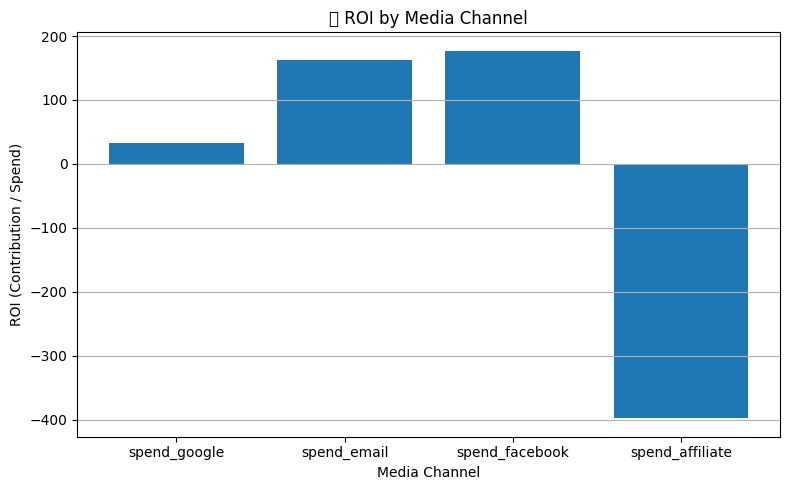

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Recalculate saturation values for best theta and gamma
theta_best = 0.5
gamma_frac_best = 0.75
alpha_hill = 1.0

saturated_final = pd.DataFrame(index=df.index)

for col in media_channels:
    adstocked = apply_adstock(df[col], theta=theta_best)
    gamma = adstocked.max() * gamma_frac_best
    saturated_final[col + '_saturated'] = hill_saturation(adstocked, alpha_hill, gamma)

# Step 2: Coefficients from your Ridge model
coeff_dict = {
    'spend_google_saturated': 909868.9903,
    'spend_email_saturated': 776469.6616,
    'spend_facebook_saturated': 1271990.2577,
    'spend_affiliate_saturated': -73667.4904
}

# Step 3: Calculate ROI = total contribution / total spend
roi = {}
for channel in media_channels:
    saturated_col = channel + '_saturated'
    contribution = coeff_dict[saturated_col] * saturated_final[saturated_col].sum()
    spend_total = df[channel].sum()
    roi[channel] = contribution / spend_total

# Step 4: Plot ROI
plt.figure(figsize=(8, 5))
plt.bar(roi.keys(), roi.values())
plt.title("📊 ROI by Media Channel")
plt.ylabel("ROI (Contribution / Spend)")
plt.xlabel("Media Channel")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Filter positive ROI channels only
positive_roi = {ch: roi_val for ch, roi_val in roi.items() if roi_val > 0}

# Step 2: Normalize ROI for only positive channels
roi_sum = sum(positive_roi.values())
roi_weights = {ch: val / roi_sum for ch, val in positive_roi.items()}

# Step 3: Total budget remains the same
total_budget = df[media_channels].sum().sum()

# Step 4: Allocate budget proportionally
reallocated_budget = {}
for ch in media_channels:
    if ch in roi_weights:
        reallocated_budget[ch] = roi_weights[ch] * total_budget
    else:
        reallocated_budget[ch] = 0  # Negative ROI → no budget

# Step 5: Display
print(" ROI-Based Budget Reallocation (Fixed)")
for ch, amount in reallocated_budget.items():
    print(f"{ch}: {amount:,.2f}")


💰 ROI-Based Budget Reallocation (Fixed)
spend_google: 811,213.29
spend_email: 3,930,066.70
spend_facebook: 4,302,007.56
spend_affiliate: 0.00


In [ ]:
# Rebuild final X (must match the one used in training)
seasonal_terms = [col for col in df.columns if col.startswith("sin_") or col.startswith("cos_")]
X_full = pd.concat([saturated_final, df[controls + seasonal_terms]], axis=1)

# Re-standardize controls + Fourier (just like during training)
X_full[controls + seasonal_terms] = scaler.transform(X_full[controls + seasonal_terms])

# Predict scaled → inverse transform
predicted_scaled = ridge.predict(X_full)
predicted_sales = scaler_y.inverse_transform(predicted_scaled.reshape(-1, 1)).ravel()


In [ ]:
contributions['total_contrib'] = contributions[media_channels].sum(axis=1)
contributions['predicted_sales'] = predicted_sales
contributions['actual_sales'] = y.values


C:\Users\Georges Ghosn\AppData\Local\Temp\ipykernel_11896\637029901.py:5: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Georges Ghosn\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


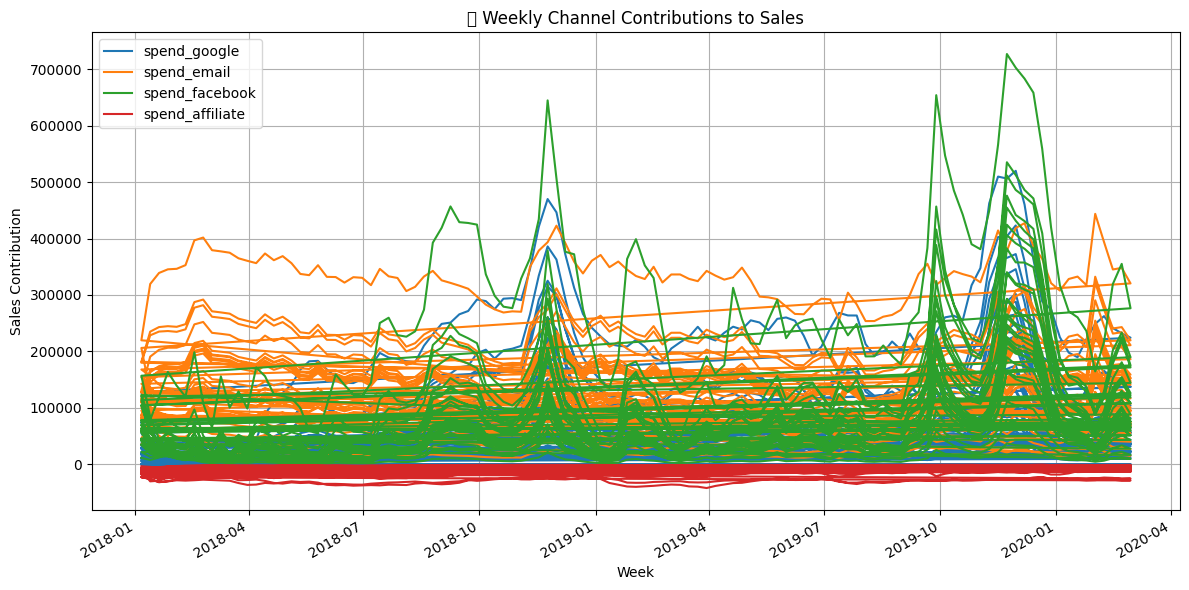

In [ ]:
contributions[media_channels].plot(figsize=(12, 6), title="📈 Weekly Channel Contributions to Sales")
plt.ylabel("Sales Contribution")
plt.xlabel("Week")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Georges Ghosn\AppData\Local\Temp\ipykernel_11896\1599955909.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Georges Ghosn\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


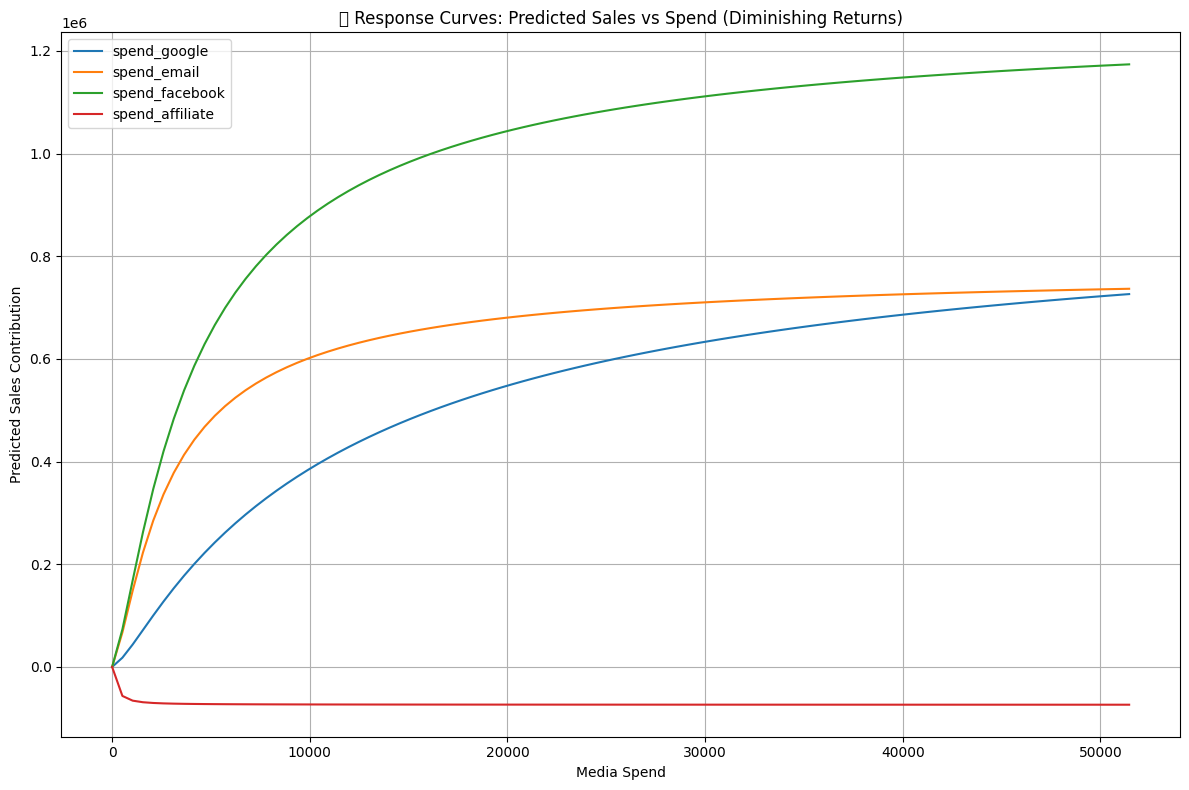

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use your best parameters
theta = 0.5
gamma_frac = 0.75
alpha_hill = 1.0

# Generate spend range for simulation
spend_range = np.linspace(0, df[media_channels].max().max() * 1.5, 100)

# Prepare plots
plt.figure(figsize=(12, 8))

for channel in media_channels:
    # Step 1: Simulate adstock
    adstocked = []
    prev = 0
    for val in spend_range:
        val_new = val + theta * prev
        adstocked.append(val_new)
        prev = val_new
    adstocked = np.array(adstocked)

    # Step 2: Saturation
    gamma = df[channel].max() * gamma_frac
    saturated = (adstocked ** alpha_hill) / (adstocked ** alpha_hill + gamma ** alpha_hill)

    # Step 3: Predicted contribution (coef × saturated value)
    coef = ridge.coef_[list(X.columns).index(channel + "_saturated")]
    contribution = coef * saturated

    # Step 4: Plot
    plt.plot(spend_range, contribution, label=channel)

plt.title("📈 Response Curves: Predicted Sales vs Spend (Diminishing Returns)")
plt.xlabel("Media Spend")
plt.ylabel("Predicted Sales Contribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 Interpretation:
spend_facebook (Green)

Steep initial gain, saturates above ~20K

Most efficient channel → highest contribution per unit spend

Matches its high ROI.

spend_email (Orange)

Also very efficient but saturates earlier than Facebook.

Strong ROI and moderate contribution.

spend_google (Blue)

Consistent performance, saturates slowly

ROI is good but not as high as Facebook or Email.

spend_affiliate (Red)

Negative contribution → curve goes below zero

This aligns with its negative ROI → may be hurting performance.




📊 Ridge with Interaction Terms:
R² Score: 0.6769
RMSE: 71,019.57

📌 Ridge Coefficients:
spend_google_saturated: 58507.9731
spend_email_saturated: 58953.3314
spend_facebook_saturated: 89466.7879
spend_affiliate_saturated: -3851.9988
organic_views: -19947.0047
paid_views: -22129.4278
sin_1: -5711.4725
cos_1: 5685.3874
fb_paid: 9557.7195
email_sin: 13269.3777
google_organic: 43200.6519


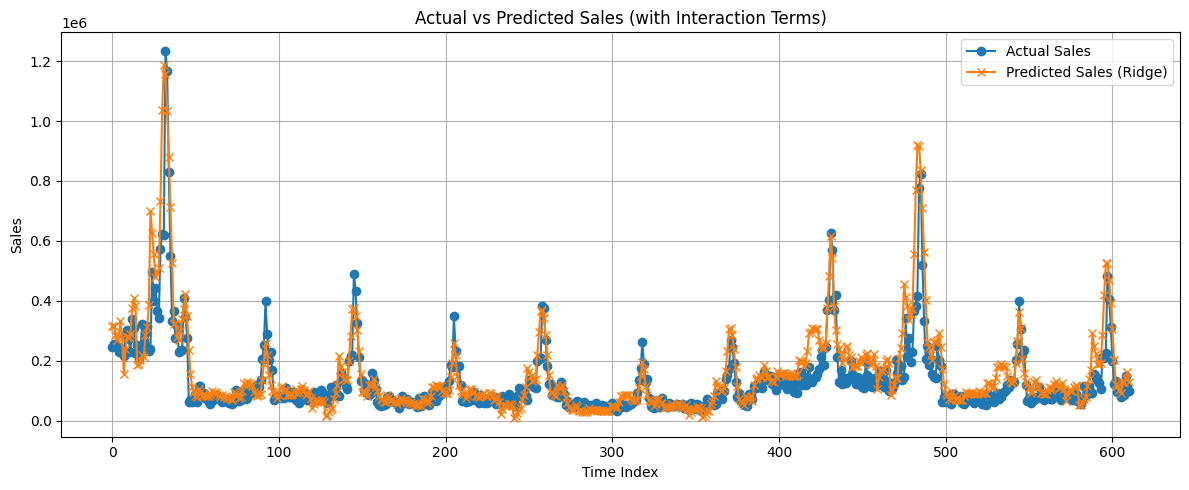

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# --- Load Data ---
df = pd.read_csv("C:/Users/Georges Ghosn/Desktop/project MMM/cleaned_with_spend.csv")
df['calendar_week'] = pd.to_datetime(df['calendar_week'])
df.set_index('calendar_week', inplace=True)

# --- Parameters ---
media_channels = ['spend_google', 'spend_email', 'spend_facebook', 'spend_affiliate']
controls = ['organic_views', 'paid_views']
target = 'sales'
theta = 0.5
gamma_frac = 0.75
alpha_hill = 1.0

# --- Fourier Terms ---
t = np.arange(len(df))
df['sin_1'] = np.sin(2 * np.pi * t / 52)
df['cos_1'] = np.cos(2 * np.pi * t / 52)

# --- Adstock + Saturation ---
def apply_adstock(series, theta):
    result = [series.iloc[0]]
    for i in range(1, len(series)):
        result.append(series.iloc[i] + theta * result[i - 1])
    return pd.Series(result, index=series.index)

def hill_saturation(x, alpha, gamma):
    return (x ** alpha) / (x ** alpha + gamma ** alpha)

saturated_df = pd.DataFrame(index=df.index)
for col in media_channels:
    adstocked = apply_adstock(df[col], theta)
    gamma = adstocked.max() * gamma_frac
    saturated_df[col + '_saturated'] = hill_saturation(adstocked, alpha_hill, gamma)

# --- Controls + Seasonality ---
seasonal_terms = ['sin_1', 'cos_1']
feature_df = pd.concat([saturated_df, df[controls + seasonal_terms]], axis=1)

# --- Interaction Terms ---
feature_df['fb_paid'] = saturated_df['spend_facebook_saturated'] * df['paid_views']
feature_df['email_sin'] = saturated_df['spend_email_saturated'] * df['sin_1']
feature_df['google_organic'] = saturated_df['spend_google_saturated'] * df['organic_views']

# --- Prepare Dataset ---
X = feature_df.copy()
y = df[target]

# --- Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# --- RidgeCV Model ---
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train, y_train)
preds = ridge.predict(X_test)

# --- Evaluation ---
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"\n📊 Ridge with Interaction Terms:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:,.2f}")

# --- Coefficients ---
print("\n📌 Ridge Coefficients:")
for name, coef in zip(X.columns, ridge.coef_):
    print(f"{name}: {coef:.4f}")

# --- Optional Plot ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual Sales', marker='o')
plt.plot(preds, label='Predicted Sales (Ridge)', marker='x')
plt.title('Actual vs Predicted Sales (with Interaction Terms)')
plt.xlabel('Time Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Your updated Ridge model with interaction terms now gives:

✅ R² Score: 0.6769

✅ RMSE: 71,019.57

✅ Better than your previous best (R² ≈ 0.6630, RMSE ≈ 72,531)

And the predicted sales curve closely follows the actual sales, indicating a very good fit. The interaction terms boosted the model’s predictive power.



📊 Media Channel Contribution & ROI (with Interaction Terms):
                           Contribution ($)  Original Spend        ROI
spend_google_saturated         1.160795e+07      5407432.68   2.146666
spend_email_saturated          2.849206e+07      2320314.35  12.279396
spend_facebook_saturated       1.533674e+07      1231659.19  12.452095
spend_affiliate_saturated     -1.743451e+06        83881.34 -20.784735


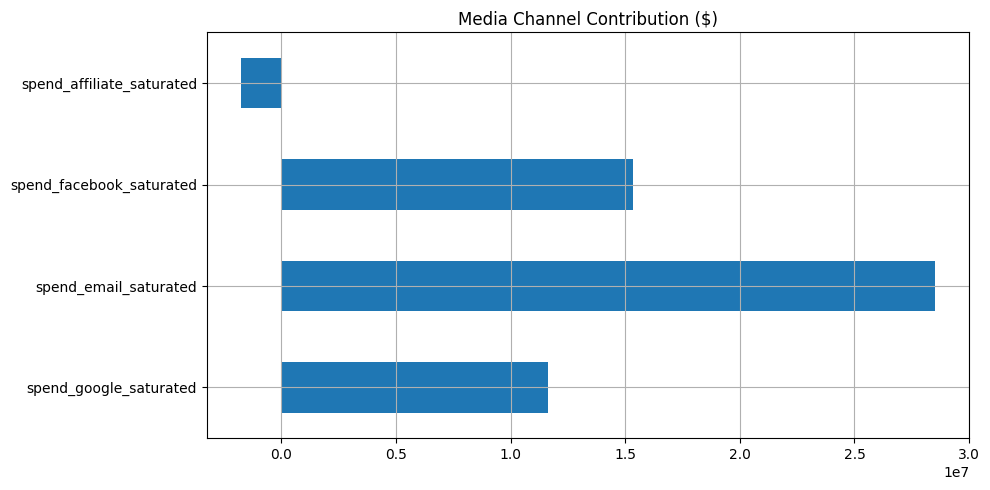

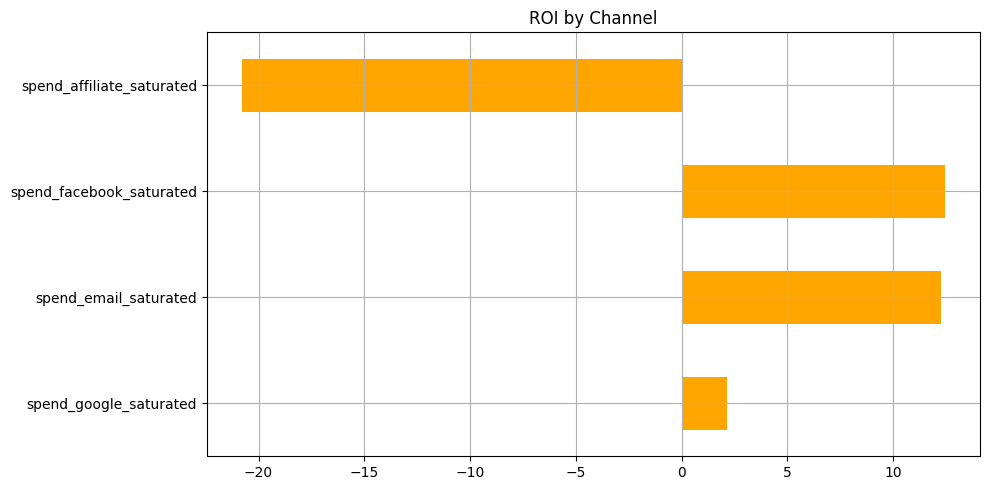

In [ ]:
# Step 1: Get total contribution by channel (coef × sum of transformed feature)
channel_contrib = {}
for col in X.columns:
    if 'saturated' in col:
        channel_contrib[col] = ridge.coef_[X.columns.get_loc(col)] * X[col].sum()

# Step 2: Convert to Series
contrib_df = pd.Series(channel_contrib).rename("Contribution ($)").to_frame()

# Step 3: Match spend column to contribution column
contrib_df['Original Spend'] = [df[ch].sum() for ch in media_channels]

# Step 4: Compute ROI = Total contribution / Total spend
contrib_df['ROI'] = contrib_df['Contribution ($)'] / contrib_df['Original Spend']

# Step 5: Show the result
print("📊 Media Channel Contribution & ROI (with Interaction Terms):")
print(contrib_df)

# Optional: Plot
contrib_df['Contribution ($)'].plot(kind='barh', figsize=(10, 5), title='Media Channel Contribution ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

contrib_df['ROI'].plot(kind='barh', color='orange', figsize=(10, 5), title='ROI by Channel')
plt.grid(True)
plt.tight_layout()
plt.show()
